# Lab 5: NLI with Attention

In this assignment we train an attention model for NLI based on [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) initial (non word-by-word) model.  Although there are more complicated attention models (see for example the word-by-word attention model), it is interesting enough to understand how attentions work and how it is possible to implement with TensorFlow.

For this we'll focus on a different NLP task: __Natural Language Inference__ (NLI). NLI consists in determining whether a natural language _hypothesis_ can justifiably be inferred from a natural language _premise_. Thus given a pair of  premise  and  hypothesis texts, the task is to classify them into three categories: _entailment_, _contradiction_, and _neutral_. The table below shows a few examples of premise/hypothesis along with the annotated labels (examples taken from [here](https://nlp.stanford.edu/pubs/snli_paper.pdf)).

The dataset we will use in this lab can be downloaded from [here](https://nlp.stanford.edu/projects/snli/) and it is a corpus comprised by The Stanford Natural Language Processing Group. Actually we are using a subset of the whole dataset. We'll more details about the dataset in the next section. 


| Premise                                                               | Category      | Hypothesis                                                         | 
|:--------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------|
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping                                                |
| An older and younger man smiling.                                  | neutral       | Two men are smiling and laughing at the cats playing on the floor. |
| A black race car starts up in front of a crowd of people.          | contradiction | A man is driving down a lonely road.                               |
| A soccer game with multiple males playing.                         | entailment    | Some men are playing a sport.                                     |
| A smiling costumed woman is holding an umbrella.                   | neutral       | A happy woman in a fairy costume holds an umbrella.                |




## Attention Model
We will make some simplification to the model presented in [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) model. In our case, the conditional encoding of the sentences is obtained usin two different ```GRU``` layers. The premise is read by one ```GRU``` and the hypothesis sentence is read by the other GRU that learns different parameters. Two ```GRU``` layers are connected in a way that the second ```GRU``` is initialized with the last cell state of the premise GRU like shown in the example (the figure is taken from [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) paper).  

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/main_arc.jpeg)

The paper proposes two attention models, we'll focus on the non word-by-word attention (Figure B), which is described in Section 2.3 of the paper. The model learns to capture important pieces of information of the premise based on the last output of the hypotesis (which contains the semantics of the hypothesis sentences). Please go through the paper to know about the mathematical details.

## Load data
In a similar way as in previous labs, we'll first load the data and inspect it. You should have you data in your drive under ```drive/My Drive/Colab Notebooks/dl4nlp_labs/data/snli/``` (the data is the same the one that you can downloaded from [here](https://nlp.stanford.edu/projects/snli/) , but we get rid off stuff we do not need this lab).

You we'll need to mount your Drive folder first to access the data. This will require one-step authentication. Please when you run the cell below follow the instructions. Once you mount everything, make sure ```snli_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/snli/``` is correct path for your data.

The cells below upload the training, development and test files:

-  ```snli_1.0_train.jsonl.bz2```
- ```snli_1.0_dev.jsonl.bz2```
-  ```snli_1.0_test.jsonl.bz2```


-----

It is good idea before we upload the data to make sure that GPUs are visible for the notebook. 

In [1]:
## check that your notebook sees a GPU, otherwise it would take for ever.
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


-----
Now we are ready to mount our Drive files:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This will take a couple of minutes to run if you load whole data, so you may want to start editing the code below at the same time. As it is now, the code is ready for debugging, it only loads 1000 examples.

You'll use Glove embeddings as well. If you want to run local, follow this instructions: If you dowloaded for the assignment 3 then edit `glove_home` to point the correct embedding file. Otherwise, if need to download them, You can do it at the following [url](http://nlp.stanford.edu/data/glove.6B.zip) (1GB). The zip file includes embeddings of different dimensionality (50d, 100d, 200d, 300d) for a vocabulary of 400000 words. Decompress them and place somewhere, for example in `./embeddings/` folder.

In [3]:
import re
import bz2
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with bz2.open(path) as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8')
            if i >= 1000000:  # Edit to use less data for debugging. set to 1000000 for testing.
                break
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data

snli_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/snli/'  
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl.bz2')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl.bz2')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl.bz2')

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary (for a class exercise) of about 36k words.

In [4]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [5]:
print(training_set[6])
print(len(word_indices))

{'annotator_labels': ['entailment'], 'captionID': '5574382134.jpg#2', 'gold_label': 'entailment', 'pairID': '5574382134.jpg#2r1e', 'sentence1': 'A little black girl is holding rocks in her hand.', 'sentence1_binary_parse': '( ( A ( little ( black girl ) ) ) ( ( is ( ( holding rocks ) ( in ( her hand ) ) ) ) . ) )', 'sentence1_parse': '(ROOT (S (NP (DT A) (JJ little) (JJ black) (NN girl)) (VP (VBZ is) (NP (NP (VBG holding) (NNS rocks)) (PP (IN in) (NP (PRP$ her) (NN hand))))) (. .)))', 'sentence2': 'A miss holds pieces of nature.', 'sentence2_binary_parse': '( ( A miss ) ( ( holds ( pieces ( of nature ) ) ) . ) )', 'sentence2_parse': '(ROOT (S (NP (DT A) (NN miss)) (VP (VBZ holds) (NP (NP (NNS pieces)) (PP (IN of) (NP (NN nature))))) (. .)))', 'label': 0, 'sentence1_binary_parse_index_sequence': array([20590, 26533, 22245, 23626, 15046, 13285,  3734, 24464, 24047,
       29549], dtype=int32), 'sentence2_binary_parse_index_sequence': array([    0,     0,     0, 25902, 26246,  6807, 12001

Now we load GloVe. You'll need to decompress the file in 'data' folder.  You'll need the same file that you used for the in-class exercise on word embeddings.

In [6]:
import bz2

glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/embeddings/'
words_to_load = 45000

with bz2.open(glove_home + 'glove.6B.50d.txt.bz2') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        line = line.decode('utf-8')
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

word = 'dog'
word_ind = word_indices[word]
print('Loaded embedding for {}:\n{}'.format(word,loaded_embeddings[word_ind]))

Loaded embedding for dog:
[ 0.11008   -0.38781   -0.57615   -0.27714    0.70521    0.53994
 -1.0786    -0.40146    1.1504    -0.5678     0.0038977  0.52878
  0.64561    0.47262    0.48549   -0.18407    0.1801     0.91397
 -1.1979    -0.5778    -0.37985    0.33606    0.772      0.75555
  0.45506   -1.7671    -1.0503     0.42566    0.41893   -0.68327
  1.5673     0.27685   -0.61708    0.64638   -0.076996   0.37118
  0.1308    -0.45137    0.25398   -0.74392   -0.086199   0.24068
 -0.64819    0.83549    1.2502    -0.51379    0.04224   -0.88118
  0.7158     0.38519  ]


Now we set up an evaluation function as before.

In [7]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignments: Build GRU pair with attention 

The intuition behind the next attention mechanism is that once we read the whole hypothesis sentence and store its semantics in the last state ($\mathbf{h}_{N}$), the model looks back in the premise text to find some useful piece of information that updates the current semantics in state $\mathbf{h}_{N}$.

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/snli_with_attention.png)

To learn attentions the paper proposes the following non-linear combinations:

 __Intermediate attention representation__: 

> $\mathbf{M} = \tanh(\mathbf{W}^{y}\mathbf{Y} + \mathbf{W}^{h}\mathbf{h}_{N}\otimes \mathbf{e}_{L})$

> in which $\mathbf{W}^y, \mathbf{W}^ĥ \in \mathbb{R}^{k\times k}$ are trained projections matrices and $\mathbf{M} \in \mathbb{R}^{k \times L}$.   $\mathbf{e}_L \in \mathbb{R^L}$ is a vector of 1s, which its functions is to repeat $L$ times the vector obtained from  $\mathbf{W}^{h}\mathbf{h}_{N}$. $L$ is the length of the sequence, and $k$ the number of hidden units of the GRU layers.


 __Attention weights__: 

> $\alpha = \text{softmax}(\mathbf{w}^T\mathbf{M}$)

> where $\mathbf{w} \in \mathbb{R}^k$ is a trained vector that parametrizes the attention given to each word in the premise, and produce a vector $\alpha \in \mathbb{R}^L$ of attention weights.

 __Attention results__: 

> $\mathbf{r} = \mathbf{Y}\alpha^T$

> where $\mathbf{r} \in \mathbb{R}^k$ is the weighted representation of the premise text.



The final __sentence-pair representation__ is obtained from a non-linear combination of the attention weighted
representation $\mathbf{r}$ of the premise and the last output vector $\mathbf{h}_N$ using

> $\mathbf{h}^{*} = \tanh(\mathbf{W}^{p}\mathbf{r} + \mathbf{W}^{x}\mathbf{h}_N)$

> where  $\mathbf{h}* \in \mathbb{R}^k$ , and $\mathbf{W}^p$, $\mathbf{W}^x$ are trained projection matrices.

-----


Run the first block of code right away to make sure you have the proper dependencies. If you are working on your machine, you may need to install [matplotlib](http://matplotlib.org/users/installing.html), which should be fairly straightforward.

### TODO:
- Fill in the missing componant below to complete Rocktäschel-style attention. Details of the attention mechanism are described in Section 2.3 of the [paper](https://arxiv.org/pdf/1509.06664v4.pdf).


- More specifically you need to implement the following two equations:

> $\mathbf{M} = \tanh(\mathbf{W}^{y}\mathbf{Y} + \mathbf{W}^{h}\mathbf{h}_{N}\otimes \mathbf{e}_{L})$ 

> $\alpha = \text{softmax}(\mathbf{w}^T\mathbf{M})$


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [10]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 5  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print out cost statistics (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 24  # The dimension of the hidden state of the RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        self.step = 1
        self.epoch = 1

        # Define the parameters
        self.trainable_variables = []
        self.E = tf.Variable(loaded_embeddings, trainable=False)
        self.trainable_variables.append(self.E)
        
        self.W_rnn = {}
        self.W_r = {}
        self.W_z = {}
        self.b_rnn = {}
        self.b_r = {}
        self.b_z = {}
        
        for self.name in ['p', 'h']:
            in_dim = self.embedding_dim
            
            self.W_rnn[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_rnn[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_rnn[self.name])
            self.trainable_variables.append(self.b_rnn[self.name])

            self.W_r[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_r[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_r[self.name])
            self.trainable_variables.append(self.b_r[self.name])

            self.W_z[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_z[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_z[self.name])
            self.trainable_variables.append(self.b_z[self.name])         

        # TODO: You'll need to use these three parameters.
        self.W_h_attn = tf.Variable(tf.random.normal([self.dim, self.dim], stddev=0.1))
        self.W_y_attn = tf.Variable(tf.random.normal([self.dim, self.dim], stddev=0.1))
        self.w_attn = tf.Variable(tf.random.normal([self.dim, 1], stddev=0.1))
        self.trainable_variables.append(self.W_h_attn)
        self.trainable_variables.append(self.W_y_attn)
        self.trainable_variables.append(self.w_attn)

        self.W_combination = tf.Variable(tf.random.normal([2 * self.dim, self.dim], stddev=0.1))
        self.b_combination = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_combination)
        self.trainable_variables.append(self.b_combination)
        
        self.W_cl = tf.Variable(tf.random.normal([self.dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([3], stddev=0.1))
        self.trainable_variables.append(self.W_cl)
        self.trainable_variables.append(self.b_cl)

    def model(self,premise_x,hypothesis_x):

        # Define the GRU function
        def gru(emb, h_prev, name):
            emb_h_prev = tf.concat([emb, h_prev], 1, name=name + '_emb_h_prev')
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z[name])  + self.b_z[name], name=name + '_z')
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r[name])  + self.b_r[name], name=name + '_r')
            emb_r_h_prev = tf.concat([emb, r * h_prev], 1, name=name + '_emb_r_h_prev')
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn[name])  + self.b_rnn[name], name=name + '_h_tilde')
            h = (1. - z) * h_prev + z * h_tilde
            return h
        
        # Define one step of the premise encoder RNN
        def premise_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'p')
        
        # Define one step of the hypothesis encoder RNN
        def hypothesis_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'h')

        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(premise_x, self.sequence_length, 1)
        self.x_hypothesis_slices = tf.split(hypothesis_x, self.sequence_length, 1)
        
        self.h_zero = tf.zeros(tf.stack([tf.shape(premise_x)[0], self.dim]))
        
        # Unroll the first RNN
        premise_h_prev = self.h_zero
        premise_steps_list = []

        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            premise_h_prev = premise_step(x_t, premise_h_prev)
            premise_steps_list.append(premise_h_prev)
            
        premise_steps = tf.stack(premise_steps_list, axis=1, name='premise_steps')
 
        # Unroll the second RNN
        h_prev_hypothesis = premise_h_prev  # Continue running the same RNN
        
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            h_prev_hypothesis = hypothesis_step(x_t, h_prev_hypothesis)
        
        # Do attention
        wm_list = []
        
        # TODO: Fill wm_list with one scalar (a.k.a., vector with one scalar for each batch entry)
        # for each word in the premise.
        # This'll likely be easiest if you use a loop to iterate over timesteps.
        # You should use the three `attn` parameters defined above, as well as `premise_steps_list`.
        
        #You need to calculate "M*wT", as "a" and "r" are already calculated below using whatever you calculated in "M"
        for y in premise_steps_list:
          M = tf.math.tanh(tf.matmul(y, self.W_y_attn) + tf.matmul(h_prev_hypothesis, self.W_h_attn))
          wm_list.append(tf.matmul(M, self.w_attn))

        # End above TODO
        
        wm = tf.stack(wm_list, axis=1)        #wm is "wT*M"
        attn_weights = tf.nn.softmax(wm, axis=1) #alphas
        attn_result = tf.reduce_sum(tf.multiply(attn_weights, premise_steps, name='attn_result_unsummed'),
                                    1, name='attn_result') #r
        
        # Combine the results of attention with the final GRU state
        concat_features = tf.concat([attn_result, h_prev_hypothesis], 1, name=self.name + '_emb_h_prev')
        pair_features = tf.nn.tanh(tf.matmul(concat_features, self.W_combination) + self.b_combination) #h*
        
        # Compute the logits
        logits = tf.matmul(pair_features, self.W_cl) + self.b_cl
        return logits,attn_weights   
        
        
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print('Training.')

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits,_ = self.model(minibatch_premise_vectors,minibatch_hypothesis_vectors)
                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))
        
                # This  performs the main SGD update equation with gradient clipping
                optimizer = tf.optimizers.Adam()
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer.apply_gradients(capped_gvs)
        

                if self.step % self.display_step_freq == 0:
                    tf.print("Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000]))
                                  
                self.step += 1
                avg_cost += total_cost / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if self.epoch % self.display_epoch_freq == 0:
                tf.print ("Epoch:", self.epoch, "Cost:", avg_cost) 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits,_ = self.model(premise_vectors,hypothesis_vectors)

        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        _,attn_weights = self.model(premise_vectors,hypothesis_vectors)
        return tf.reshape(attn_weights, [len(examples), 10, 1])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(np.transpose(attn_weights[i,:,:]), vmin=0., vmax=1., cmap=plt.cm.inferno)
            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]
            plt.text(0, 1, 'H: ' + ' '.join(hypothesis_tokens))
            ax.set_xticklabels(premise_tokens, rotation=45)
            plt.xticks(np.arange(0, 10, 1.0))

Next, create an instance of the model. Unlike in previous exercises, initialization happens here, rather than at the start of training. You can now initialize a model once and start and stop training as needed.

In [11]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

In implementing attention, it's easy to accidentally mix information between )different examples in a batch. This assertion will fail if you've done so. Run it whenever you edit core model code.

In [12]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).numpy().all(), \
       'Warning: There is cross-example information flow.'

Running the training long enough __on the whole training set__, you may get around 62% dev accuracy. This should take around five or ten minutes (or maybe more). This isn't great performance, but it's good enough that we should start to see attention play a role. If you have extra time, run longer.

In [13]:
classifier.train(training_set, dev_set)

Training.
Step: 250 Dev acc: 0.504 Train acc: 0.478
Step: 500 Dev acc: 0.524 Train acc: 0.505
Step: 750 Dev acc: 0.53 Train acc: 0.51
Step: 1000 Dev acc: 0.548 Train acc: 0.528
Step: 1250 Dev acc: 0.559 Train acc: 0.537
Step: 1500 Dev acc: 0.583 Train acc: 0.55
Step: 1750 Dev acc: 0.571 Train acc: 0.558
Step: 2000 Dev acc: 0.568 Train acc: 0.559
Step: 2250 Dev acc: 0.582 Train acc: 0.55
Step: 2500 Dev acc: 0.585 Train acc: 0.566
Step: 2750 Dev acc: 0.568 Train acc: 0.561
Step: 3000 Dev acc: 0.592 Train acc: 0.586
Step: 3250 Dev acc: 0.583 Train acc: 0.568
Step: 3500 Dev acc: 0.583 Train acc: 0.565
Step: 3750 Dev acc: 0.59 Train acc: 0.576
Step: 4000 Dev acc: 0.586 Train acc: 0.585
Step: 4250 Dev acc: 0.575 Train acc: 0.587
Step: 4500 Dev acc: 0.591 Train acc: 0.58
Step: 4750 Dev acc: 0.595 Train acc: 0.597
Step: 5000 Dev acc: 0.601 Train acc: 0.6
Step: 5250 Dev acc: 0.595 Train acc: 0.604
Step: 5500 Dev acc: 0.606 Train acc: 0.595
Step: 5750 Dev acc: 0.593 Train acc: 0.583
Step: 6000 D

## Visualization

This will print some (NYU-colored) visualizations for the first ten dev examples. Explore these examples and more, and see if you can identify any patterns in what the model has learned.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


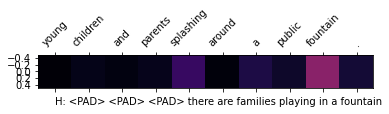

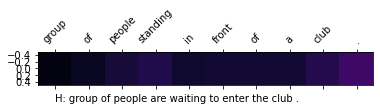

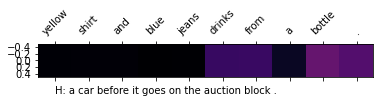

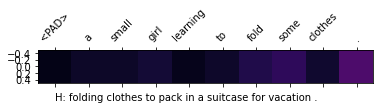

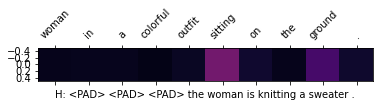

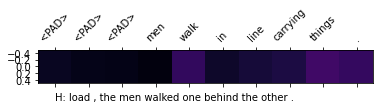

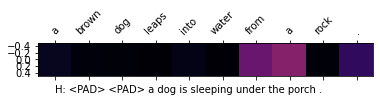

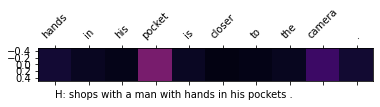

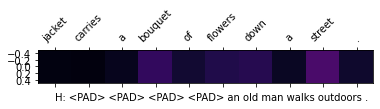

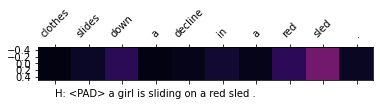

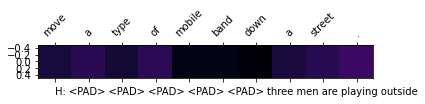

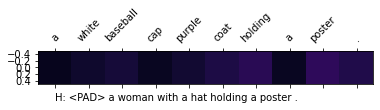

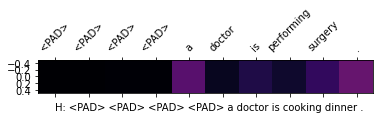

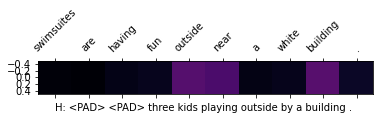

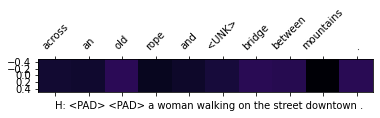

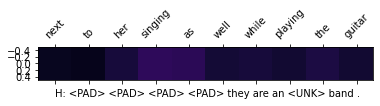

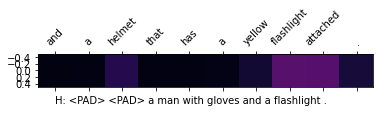

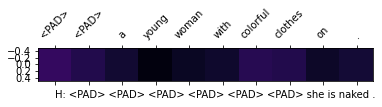

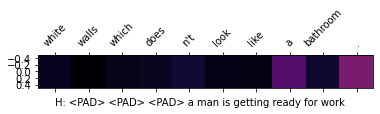

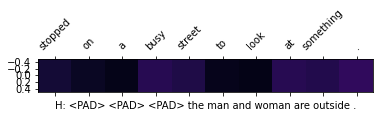

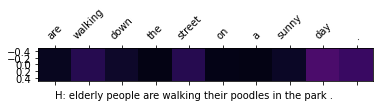

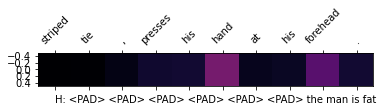

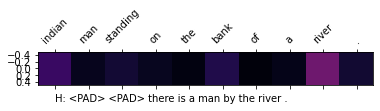

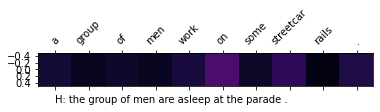

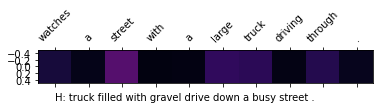

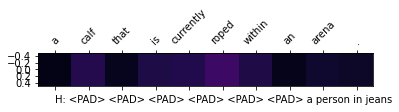

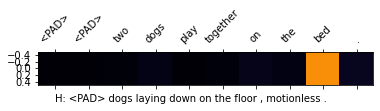

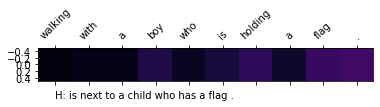

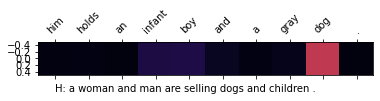

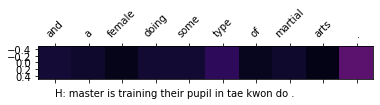

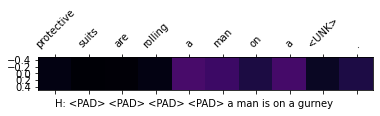

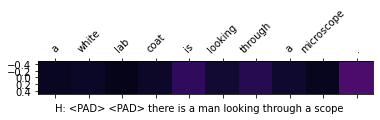

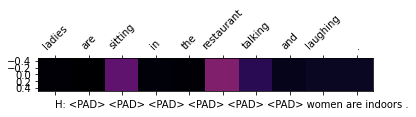

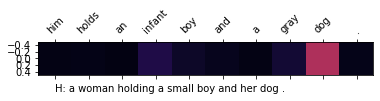

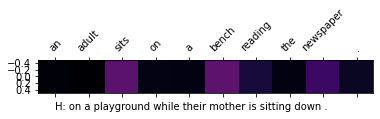

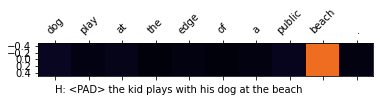

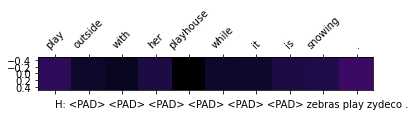

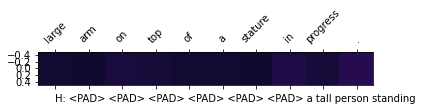

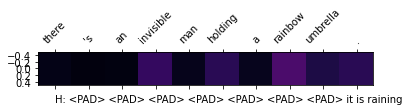

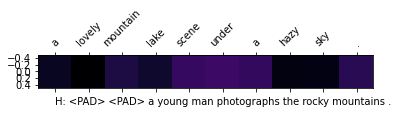

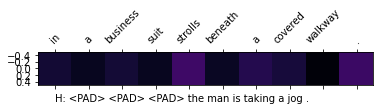

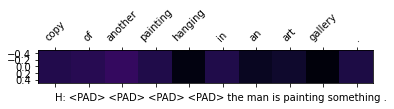

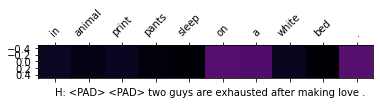

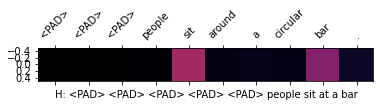

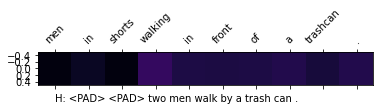

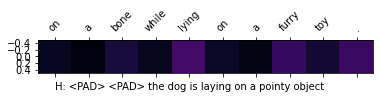

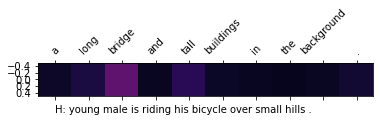

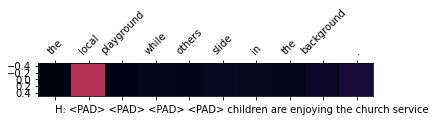

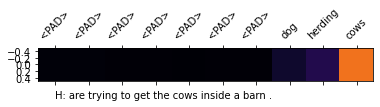

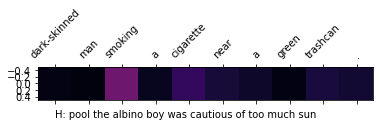

In [14]:
classifier.plot_attn(dev_set[0:50])

# Atribution:
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on a notebook by Sam Bowman at NYU